In [1]:
import gym
import random, math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
from scripts.reinforce_rwd2go import reinforce_rwd2go, rollout, make_pref_dataset
from scripts.utils import pref_save, pref_load

from scripts.model import getPolicy
import pickle

%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
SEED=0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

ENV_NAME = 'Pendulum-v1'

env = gym.make(ENV_NAME)

K = 1000

In [4]:
from scripts.reinforce_rwd2go import reinforce_rwd2go_2

policy = getPolicy(ENV_NAME=ENV_NAME).to(device)
opt = optim.Adam(policy.parameters(), lr=1e-2)

print("=== Training π₁ to get π₁ and π₂ ===")
scores, step_policy2_max, step_policy2_mean, step_policy1 = reinforce_rwd2go_2(env, policy, opt, env,
                                                                                n_episodes=2000, print_every=100, near_max_reward=-150)


=== Training π₁ to get π₁ and π₂ ===
Ep 100	avg100: -1536.62
Ep 200	avg100: -1542.89
Ep 300	avg100: -1463.84
Ep 400	avg100: -1435.88
Ep 500	avg100: -1398.10
Ep 600	avg100: -1383.99
Ep 700	avg100: -1427.16
Ep 800	avg100: -1400.33
Ep 900	avg100: -1457.51
Ep 1000	avg100: -1422.39
Ep 1100	avg100: -1448.14
Ep 1200	avg100: -1446.19
Ep 1300	avg100: -1452.68
Ep 1400	avg100: -1441.98
Ep 1500	avg100: -1463.08
Ep 1600	avg100: -1422.07
Ep 1700	avg100: -1441.71
Ep 1800	avg100: -1443.51
Ep 1900	avg100: -1426.69
Ep 2000	avg100: -1451.72


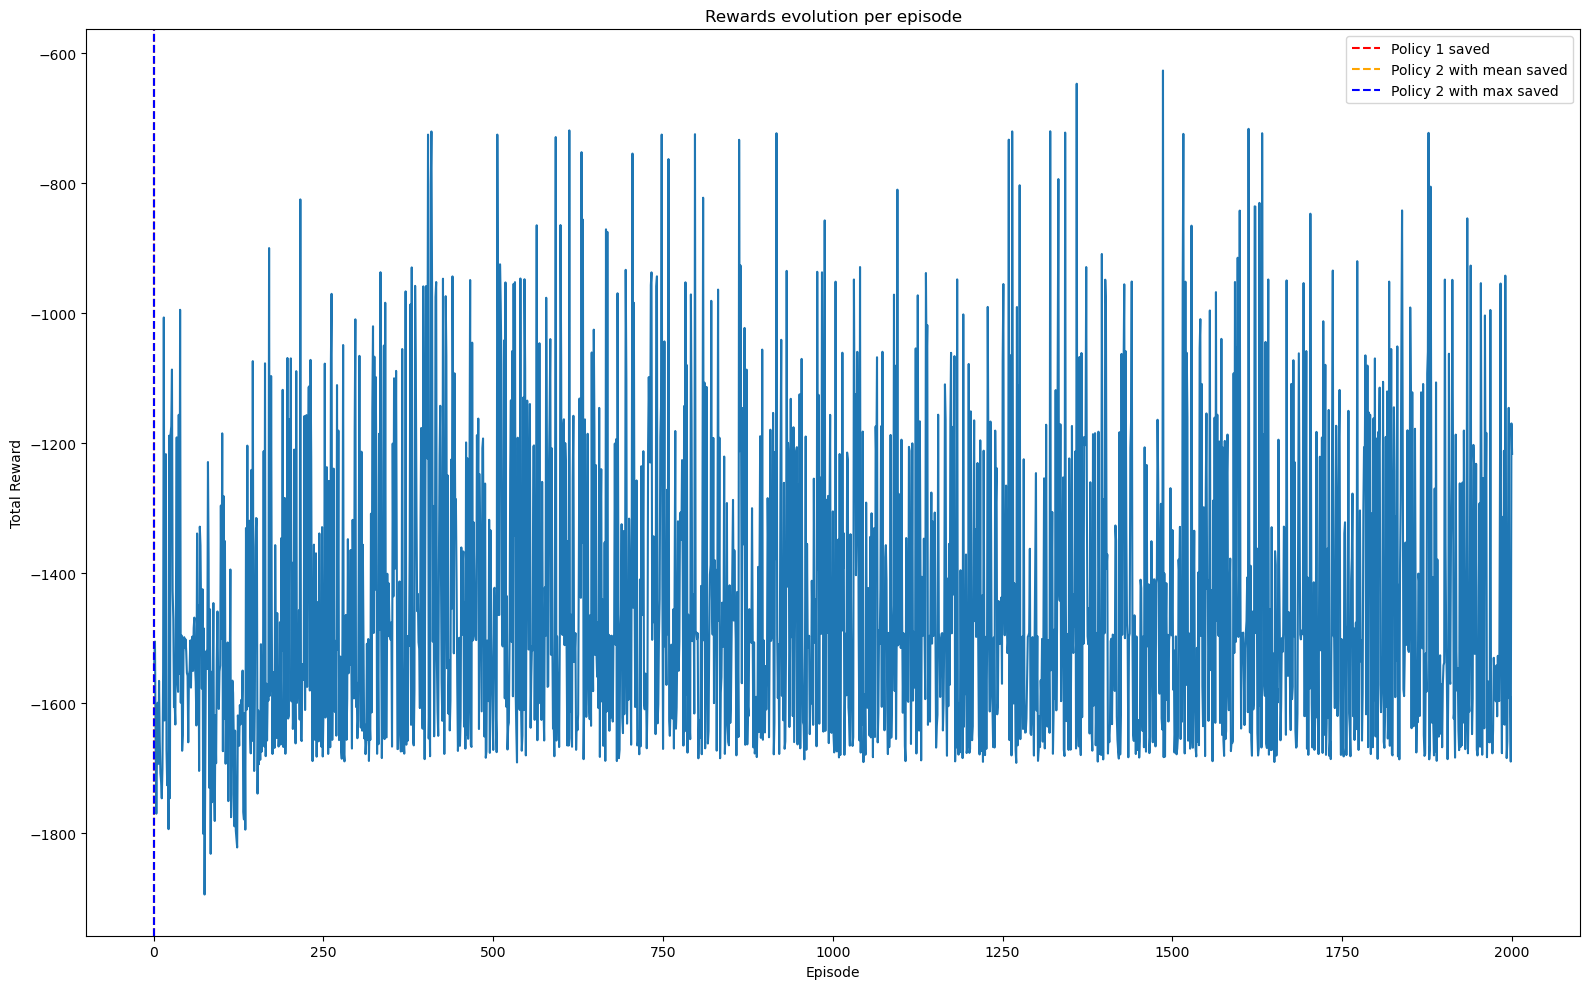

In [5]:
import matplotlib.pyplot as plt

def plot_rewards(scores, window=100, figsize=(10, 6), policy1_step=None, policy2_step_mean=None, policy2_step_max=None):
    episodes = list(range(1, len(scores) + 1))

    plt.figure()
    plt.plot(episodes, scores)

    if policy1_step is not None:
        plt.axvline(policy1_step, color='red', linestyle='--', label="Policy 1 saved")
    if policy2_step_mean is not None:
        plt.axvline(policy2_step_mean, color='orange', linestyle='--', label="Policy 2 with mean saved")
    if policy2_step_max is not None:
        plt.axvline(policy2_step_max, color='blue', linestyle='--', label="Policy 2 with max saved")
    
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Rewards evolution per episode")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_rewards(scores, policy1_step=step_policy1, policy2_step_mean=step_policy2_mean, policy2_step_max=step_policy2_max)

In [6]:
policy1 = getPolicy(ENV_NAME=ENV_NAME).to(device)
policy1.load_state_dict(torch.load(f"policies/policy1.pth"))
policy2 = getPolicy(ENV_NAME=ENV_NAME).to(device)
policy2.load_state_dict(torch.load(f"policies/policy2_with_max.pth"))

FileNotFoundError: [Errno 2] No such file or directory: 'policies/policy1.pth'

In [11]:
K = 100
print(f"Generating {K} preference pairs …")
pref_data = make_pref_dataset(policy1, policy2, env, K)
pref_save(pref_data, f"pref_data/pref_data_{K}_{ENV_NAME}.pickle")
print("Finished")

Generating 100 preference pairs …


NameError: name 'policy2' is not defined

In [ ]:
policy1 = getPolicy(ENV_NAME=ENV_NAME).to(device)
opt1    = optim.Adam(policy1.parameters(), lr=1e-2)

print("=== Training π₁ ===")
scores1 = reinforce_rwd2go(env, policy1, opt1, env,
                            n_episodes=2000, print_every=100,
                            target_reward=None, near_max_reward=195, gamma=0.95)
avg1 = np.mean(scores1[-100:])
print(f"Final π₁ avg100: {avg1:.2f}\n")

In [62]:
policy2 = getPolicy(ENV_NAME=ENV_NAME).to(device)
opt2    = optim.Adam(policy2.parameters(), lr=1e-2)
half_target = avg1 / 2.0

print("=== Training π₂ ===")
scores2 = reinforce_rwd2go(env, policy2, opt2, env,
                            n_episodes=2000, print_every=100,
                            target_reward=half_target, near_max_reward=195)
avg2 = np.mean(scores2[-100:])
print(f"Final π₂ avg100: {avg2:.2f}\n")

=== Training π₂ ===
Ep 100	avg100: 45.97
Reached target 97.7 at ep 104 (avg=48.1)
Final π₂ avg100: 48.11



In [63]:
print(f"Generating {K} preference pairs …")
pref_data = make_pref_dataset(policy1, policy2, env, K)
pref_save(pref_data, f"pref_data_{K}_{ENV_NAME}.pickle")
print("Finished")

torch.save(policy1.state_dict(), f"policy1_{K}_{ENV_NAME}.pth")
torch.save(policy2.state_dict(), f"policy2_{K}_{ENV_NAME}.pth")

Generating 1000 preference pairs …
Mean p1 199.793
Mean p2 72.225
Finished
